In [10]:
!pip freeze > ../requirements.txt

In [13]:
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 52.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 44.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
import os
import json
import torch
import cv2
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from ultralytics import YOLO
from tqdm import tqdm


WARNING ⚠️ user config directory '/root/.config/Ultralytics' is not writeable, defaulting to '/tmp' or CWD.Alternatively you can define a YOLO_CONFIG_DIR environment variable for this path.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/tmp/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:

# def get_age_group(age):
#     if 0 <= age <= 10:
#         return 0
#     elif 11 <= age <= 15:
#         return 1
#     elif 16 <= age <= 23:
#         return 2
#     elif 26 <= age <= 34:
#         return 3
#     elif 37 <= age <= 43:
#         return 4
#     elif age >= 45:
#         return 5
def get_age_group(age):
    # 0: 0~10, 1: 10~20, 2: 20~30, 3: 30~40, 4: 40~50, 5: 50세 이상
    if age < 10:
        return 0
    elif age < 20:
        return 1
    elif age < 30:
        return 2
    elif age < 40:
        return 3
    elif age < 50:
        return 4
    else:
        return 5
        
class JSONFacesDataset(Dataset):
    def __init__(self, json_path, images_folder, transform=None):
        self.data = []
        self.transform = transform
        self.images_folder = images_folder
        if os.path.isdir(json_path):
            json_files = sorted([os.path.join(json_path, f) for f in os.listdir(json_path) if f.endswith('.json')])
            for jf in json_files:
                try:
                    with open(jf, 'r', encoding='cp1252', errors='replace') as f:
                        content = f.read().strip()
                        if not content:
                            continue
                        annotation = json.loads(content)
                except json.JSONDecodeError:
                    continue
                if "age_past" not in annotation:
                    continue
                if "filename" not in annotation:
                    annotation["filename"] = os.path.splitext(os.path.basename(jf))[0]
                file_format = annotation.get("format", "png").lower()
                image_file = f"{annotation['filename']}.{file_format}"
                image_path = os.path.join(self.images_folder, image_file)
                if not os.path.exists(image_path):
                    continue
                self.data.append(annotation)
        else:
            try:
                with open(json_path, 'r', encoding='cp1252', errors='replace') as f:
                    content = f.read().strip()
                    if content:
                        self.data = json.loads(content)
                    else:
                        self.data = []
            except json.JSONDecodeError:
                self.data = []

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        filename = entry["filename"]
        age = entry["age_past"]
        age_group = get_age_group(int(age))
        gender_str = entry["gender"]
        gender = 1 if gender_str.lower() == "male" else 0
        file_format = entry.get("format", "png").lower()
        image_file = f"{filename}.{file_format}"
        image_path = os.path.join(self.images_folder, image_file)
        image = Image.open(image_path).convert("RGB")
        
        # 박스 정보가 있으면 얼굴 영역을 크롭 (마진을 추가하여 확장)
        if "annotation" in entry and len(entry["annotation"]) > 0:
            ann = entry["annotation"][0]
            if "box" in ann:
                box = ann["box"]
                x = float(box["x"])
                y = float(box["y"])
                w = float(box["w"])
                h = float(box["h"])
                
                # 마진 추가 (예: 10% 마진)
                margin = 0.1
                new_x = x - margin * w
                new_y = y - margin * h
                new_w = w * (1 + 2 * margin)
                new_h = h * (1 + 2 * margin)
                
                # 원본 이미지 크기 내로 경계 보정
                img_width, img_height = image.size
                new_x = max(0, new_x)
                new_y = max(0, new_y)
                new_x2 = min(img_width, new_x + new_w)
                new_y2 = min(img_height, new_y + new_h)
                
                image = image.crop((int(new_x), int(new_y), int(new_x2), int(new_y2)))
        
        if self.transform:
            image = self.transform(image)
        return image, age_group, gender


In [4]:
import os
import json
from collections import Counter

# JSON 어노테이션이 저장된 디렉토리와 원본 이미지가 저장된 디렉토리 경로 
#json_dir = "../data2/labeling"
#images_folder = "../data2/original"
json_dir = "../data2/validation/labeling"
images_folder = "../data2/validation/original"

missing_files = []
total_files = 0

for filename in os.listdir(json_dir):
    if filename.endswith('.json'):
        json_path = os.path.join(json_dir, filename)
        with open(json_path, 'r', encoding='cp1252', errors='replace') as f:
            try:
                annotation = json.load(f)
            except json.JSONDecodeError:
                print(f"JSON decode error in {json_path}, skipping.")
                continue
        
        # JSON 파일 내에 "filename" 키가 있으면 사용, 없으면 JSON 파일명(확장자 제거)을 사용
        if "filename" in annotation:
            base_filename = annotation["filename"]
        else:
            base_filename = os.path.splitext(filename)[0]
        
        # base_filename에 이미 확장자가 포함되어 있으면 그대로 사용, 없으면 annotation의 format(없으면 png)을 붙임
        ext = os.path.splitext(base_filename)[1]
        if ext:
            expected_image = base_filename
        else:
            file_format = annotation.get("format", "png").lower()
            expected_image = f"{base_filename}.{file_format}"
        
        image_path = os.path.join(images_folder, expected_image)
        
        total_files += 1
        if not os.path.exists(image_path):
            # case-insensitive 체크: 폴더 내 모든 파일명을 소문자로 변환하여 비교
            folder_files = os.listdir(images_folder)
            match = [f for f in folder_files if f.lower() == expected_image.lower()]
            if not match:
                missing_files.append(expected_image)

print(f"Total JSON files processed: {total_files}")
if missing_files:
    print(f"Missing image files ({len(missing_files)}):")
    for mf in missing_files:
        print(mf)
else:
    print("All expected image files exist.")

# 접두사(앞의 4자리 숫자)별 누락 개수 계산
prefix_counter = Counter(mf[:4] for mf in missing_files)

print("Missing image files grouped by prefix:")
for prefix, count in sorted(prefix_counter.items()):
    print(f"{prefix}: {count} missing files")


Total JSON files processed: 5050
All expected image files exist.
Missing image files grouped by prefix:


In [5]:
# --- 데이터 증강 및 전처리 ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),         # 랜덤 수평 뒤집기
    transforms.RandomRotation(5),             # 최대 ±5도 회전
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_json = "../data2/labeling"
train_images_folder = "../data2/original"
val_json = "../data2/validation/labeling"
val_images_folder = "../data2/validation/original"

train_dataset = JSONFacesDataset(train_json, train_images_folder, transform=transform)
val_dataset = JSONFacesDataset(val_json, val_images_folder, transform=transform)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

# --- 클래스 가중치 계산 (나이 그룹별) ---
age_group_counter = Counter()
for entry in train_dataset.data:
    try:
        age = int(entry["age_past"])
        age_group = get_age_group(age)
        age_group_counter[age_group] += 1
    except Exception as e:
        print("Error processing entry:", e)
total_samples = sum(age_group_counter.values())
num_classes = 6
class_weights = {group: total_samples / (num_classes * count) for group, count in age_group_counter.items()}
weights_list = [class_weights[i] for i in range(num_classes)]
age_weights_tensor = torch.FloatTensor(weights_list)
print("Class weights:", weights_list)

Class weights: [0.7789071932079292, 0.545866426485439, 0.813206473123526, 1.2505471143625335, 2.391200382592061, 2.2901637467078895]


In [11]:
from collections import Counter

# group_names 딕셔너리 정의 (이전에 정의한 적이 없다면 반드시 포함)
# group_names = {0: "0~10", 1: "11~25", 2: "16~23", 3: "26~34", 4: "37~43", 5: "45 이상"}
group_names = {0: "0~10", 1: "10~20", 2: "20~30", 3: "30~40", 4: "40~50", 5: "50 이상"}

# JSON 어노테이션 데이터만 활용하여 나이 그룹별 샘플 개수 카운트
age_group_counter = Counter()
for entry in train_dataset.data:
    try:
        age = int(entry["age_past"])
        age_group = get_age_group(age)
        age_group_counter[age_group] += 1
    except Exception as e:
        print(f"Error processing entry: {e}")

print("나이 그룹별 데이터 개수 (JSON 어노테이션 기반):")
for group in sorted(age_group_counter.keys()):
    print(f"Group {group} ({group_names[group]}): {age_group_counter[group]} samples")


나이 그룹별 데이터 개수 (JSON 어노테이션 기반):


TypeError: '<' not supported between instances of 'NoneType' and 'int'

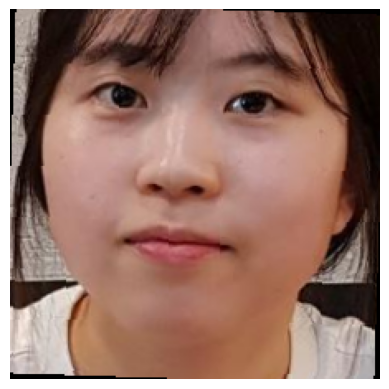

Age Group: 20~30 Gender: Female


In [19]:
import random
import matplotlib.pyplot as plt
import numpy as np

def imshow_tensor(img_tensor):
    img = img_tensor.cpu().numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

# group_names = {0: "0~10", 1: "11~15", 2: "16~23", 3: "26~34", 4: "37~43", 5: "45 이상"}
group_names = {0: "0~10", 1: "10~20", 2: "20~30", 3: "30~40", 4: "40~50", 5: "50 이상"}

# 무작위 인덱스 선택
import random
idx = random.randint(0, len(train_dataset) - 1)
try:
    image, age_group, gender = train_dataset[idx]
    imshow_tensor(image)
    print("Age Group:", group_names[age_group], "Gender:", "Male" if gender == 1 else "Female")
except FileNotFoundError as e:
    print("File not found:", e)


In [8]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash", None)
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
efficientnet_b0(weights="DEFAULT")

class MultiTaskEfficientNet(nn.Module):
    def __init__(self, num_gender_classes=2, num_age_groups=6):
        super(MultiTaskEfficientNet, self).__init__()
        weights = EfficientNet_B0_Weights.DEFAULT
        self.backbone = models.efficientnet_b0(weights=weights)
        num_features = self.backbone.classifier[1].in_features
        # EfficientNet의 classifier 제거 및 global average pooling 사용 (이미 EfficientNet은 글로벌 풀링 포함)
        self.backbone.classifier = nn.Identity()
        
        # 성별 분류 헤드 (변경 없음)
        self.gender_head = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Linear(128, num_gender_classes)
        )
        # 나이 분류 헤드 강화: 추가 레이어, BatchNorm, Dropout 적용
        self.age_head = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.45),  # 논문에서 dropout rate 0.45 적용
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_age_groups)
        )
        
    def forward(self, x):
        features = self.backbone(x)
        gender_logits = self.gender_head(features)
        age_logits = self.age_head(features)
        return gender_logits, age_logits

model = MultiTaskEfficientNet(num_gender_classes=2, num_age_groups=6)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 65.7MB/s]


MultiTaskEfficientNet(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
           

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1, weight=None):
        """
        :param classes: 전체 클래스 수 (예: 6)
        :param smoothing: 스무딩 계수 (예: 0.1)
        :param weight: 각 클래스에 적용할 가중치 tensor (예: age_weights_tensor)
        """
        super(LabelSmoothingLoss, self).__init__()
        self.classes = classes
        self.smoothing = smoothing
        self.weight = weight  # shape: [classes]
        
    def forward(self, input, target):
        # input: [batch, classes], target: [batch]
        confidence = 1.0 - self.smoothing
        log_probs = F.log_softmax(input, dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(log_probs)
            true_dist.fill_(self.smoothing / (self.classes - 1))
            true_dist.scatter_(1, target.unsqueeze(1), confidence)
        # 각 샘플별 손실 계산
        loss = torch.sum(-true_dist * log_probs, dim=-1)  # shape: [batch]
        if self.weight is not None:
            # target에 해당하는 가중치를 가져와서 각 샘플의 손실에 곱함
            sample_weights = self.weight.gather(0, target)
            loss = loss * sample_weights
        return loss.mean()


In [9]:
import torch.nn.functional as F

# --- Optimizer 및 Scheduler ---
optimizer = optim.Adam([
    {"params": model.backbone.parameters(), "lr": 5e-5},
    {"params": list(model.gender_head.parameters()) + list(model.age_head.parameters()), "lr": 1e-4}
], weight_decay=0.03)  # L2 regularization (weight decay)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,          # 예: 5 에폭 동안 개선 없으면 학습률 감소
    verbose=True,
    min_lr=1e-6          # 학습률이 1e-6 이하로 떨어지지 않도록 설정
)

def focal_loss(inputs, targets, weight=None, alpha=1.0, gamma=2.0):
    # 각 샘플에 대해 cross entropy loss 계산 (reduction='none')
    ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=weight)
    pt = torch.exp(-ce_loss)  # 잘 예측한 샘플일수록 pt가 높음
    loss = alpha * (1 - pt) ** gamma * ce_loss
    return loss.mean()

# --- 손실 함수 ---
criterion_gender = nn.CrossEntropyLoss()
lambda_age = 3.0  # 나이 손실에 세 배 중요도 부여

# 최고 나이 그룹 정확도를 추적하기 위한 변수 초기화
best_age_acc   = 0.0
best_val_loss  = float('inf')

# --- 학습 및 Validation 루프 ---
num_epochs = 30  
patience = 7  
patience_cnt = 0

# ----------------------------- 1. 로그 버퍼 ---------------------------------- 
hist = {
    "train_loss": [], "val_loss": [],
    "train_age_acc": [], "val_age_acc": [],
    "train_gender_acc": [], "val_gender_acc": []
}

for epoch in range(num_epochs):
    # ------------------ Train -----------------------------------------------
    model.train()
    train_loss = 0.0
    train_correct_age = 0          
    train_correct_gender = 0       
    total_train = 0                

    pbar_train = tqdm(train_loader, desc=f"[{epoch+1}/{num_epochs}] Train", leave=False)
    for images, age_groups, genders in pbar_train:
        images   = images.to(device, non_blocking=True)
        age_groups = age_groups.to(device, non_blocking=True)
        genders    = genders.to(device, non_blocking=True)

        optimizer.zero_grad()
        gender_logits, age_logits = model(images)

        loss_gender = criterion_gender(gender_logits, genders)
        loss_age    = focal_loss(age_logits, age_groups,
                                 weight=age_weights_tensor.to(device),
                                 alpha=1.0, gamma=2.0)
        loss = loss_gender + lambda_age * loss_age
        loss.backward()
        optimizer.step()

        batch_size = images.size(0)
        train_loss += loss.item() * batch_size

        # ---------- accuracy 누적 ---------------- ★
        train_correct_gender += (gender_logits.argmax(1) == genders).sum().item()
        train_correct_age    += (age_logits.argmax(1)    == age_groups).sum().item()
        total_train          += batch_size

        pbar_train.set_postfix(loss=f"{loss.item():.3f}")

    avg_train_loss        = train_loss / total_train
    train_gender_acc_epoch= train_correct_gender / total_train  # ★
    train_age_acc_epoch   = train_correct_age    / total_train  # ★

    # ------------------ Validation ------------------------------------------
    model.eval()
    val_loss = 0.0
    correct_gender = correct_age = total_val = 0

    pbar_val = tqdm(val_loader, desc=f"[{epoch+1}/{num_epochs}] Valid", leave=False)
    for images, age_groups, genders in pbar_val:
        images     = images.to(device, non_blocking=True)
        age_groups = age_groups.to(device, non_blocking=True)
        genders    = genders.to(device, non_blocking=True)

        with torch.no_grad():
            gender_logits, age_logits = model(images)
            loss_gender = criterion_gender(gender_logits, genders)
            loss_age    = focal_loss(age_logits, age_groups)
            loss = loss_gender + lambda_age * loss_age

        batch_size = images.size(0)
        val_loss += loss.item() * batch_size

        correct_gender += (gender_logits.argmax(1) == genders).sum().item()
        correct_age    += (age_logits.argmax(1)    == age_groups).sum().item()
        total_val      += batch_size

        pbar_val.set_postfix(loss=f"{loss.item():.3f}")

    avg_val_loss = val_loss / total_val
    gender_acc   = correct_gender / total_val
    age_acc      = correct_age    / total_val

    # ------------------ 로그 버퍼 저장 -------------------------------------- ★
    hist["train_loss"].append(avg_train_loss)
    hist["val_loss"].append(avg_val_loss)
    hist["train_age_acc"].append(train_age_acc_epoch)
    hist["val_age_acc"].append(age_acc)
    hist["train_gender_acc"].append(train_gender_acc_epoch)
    hist["val_gender_acc"].append(gender_acc)

    # ------------------ 출력 --------------------------------------------------
    print(f"\nEpoch {epoch+1}/{num_epochs} | "
          f"TLoss {avg_train_loss:.3f}  VLoss {avg_val_loss:.3f} | "
          f"GenAcc T {train_gender_acc_epoch:.3f} V {gender_acc:.3f} | "
          f"AgeAcc T {train_age_acc_epoch:.3f} V {age_acc:.3f}")

    # ------------------ 체크포인트 -------------------------------------------
    if age_acc > best_age_acc:
        best_age_acc = age_acc
        torch.save(model.state_dict(), "best_checkpoint_age.pt")
        print(f"  ↳ New best age-group acc {best_age_acc:.4f}  (checkpoint saved)")

    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_cnt  = 0
    else:
        patience_cnt += 1
        if patience_cnt >= patience:
            print("Early stopping triggered.")
            break


[1/30] Train:  37%|███▋      | 58/157 [03:52<10:38,  6.45s/it, loss=3.795] /usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
[1/30] Train:  63%|██████▎   | 99/157 [06:20<05:49,  6.02s/it, loss=3.404]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1/30 | TLoss 3.779  VLoss 3.113 | GenAcc T 0.720 V 0.811 | AgeAcc T 0.297 V 0.371
  ↳ New best age-group acc 0.3713  (checkpoint saved)


[2/30] Train:  30%|██▉       | 47/157 [03:07<03:47,  2.07s/it, loss=2.797] /usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
[2/30] Train:  51%|█████     | 80/157 [05:05<02:06,  1.64s/it, loss=2.411]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 2/30 | TLoss 2.725  VLoss 2.342 | GenAcc T 0.828 V 0.878 | AgeAcc T 0.462 V 0.483
  ↳ New best age-group acc 0.4831  (checkpoint saved)


[3/30] Train:   0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
[3/30] Train:  63%|██████▎   | 99/157 [06:25<02:52,  2.98s/it, loss=1.993] /usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 3/30 | TLoss 2.248  VLoss 2.124 | GenAcc T 0.862 V 0.897 | AgeAcc T 0.531 V 0.520
  ↳ New best age-group acc 0.5204  (checkpoint saved)


[4/30] Train:   3%|▎         | 4/157 [00:36<13:11,  5.18s/it, loss=1.839]  /usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
[4/30] Train:  18%|█▊        | 28/157 [01:59<05:36,  2.61s/it, loss=2.045]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 4/30 | TLoss 1.964  VLoss 1.975 | GenAcc T 0.880 V 0.906 | AgeAcc T 0.567 V 0.538
  ↳ New best age-group acc 0.5383  (checkpoint saved)


[5/30] Train:  10%|█         | 16/157 [01:10<03:15,  1.39s/it, loss=1.693] /usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
[5/30] Train:  71%|███████▏  | 112/157 [06:56<01:40,  2.23s/it, loss=1.819]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 5/30 | TLoss 1.764  VLoss 1.884 | GenAcc T 0.893 V 0.915 | AgeAcc T 0.594 V 0.549
  ↳ New best age-group acc 0.5487  (checkpoint saved)


[6/30] Train:   1%|          | 1/157 [00:31<1:23:04, 31.95s/it, loss=1.524]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
[6/30] Train:  63%|██████▎   | 99/157 [06:23<04:57,  5.12s/it, loss=1.483] /usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 6/30 | TLoss 1.616  VLoss 1.722 | GenAcc T 0.900 V 0.916 | AgeAcc T 0.616 V 0.575
  ↳ New best age-group acc 0.5750  (checkpoint saved)


[7/30] Train:   4%|▍         | 7/157 [00:39<04:23,  1.76s/it, loss=1.365]  /usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
[7/30] Train:   5%|▌         | 8/157 [00:40<03:13,  1.30s/it, loss=1.707]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 7/30 | TLoss 1.492  VLoss 1.678 | GenAcc T 0.905 V 0.920 | AgeAcc T 0.630 V 0.584
  ↳ New best age-group acc 0.5844  (checkpoint saved)


[8/30] Train:  20%|██        | 32/157 [02:07<02:12,  1.06s/it, loss=1.341] /usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
[8/30] Train:  27%|██▋       | 42/157 [03:03<10:46,  5.62s/it, loss=1.229]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 8/30 | TLoss 1.382  VLoss 1.897 | GenAcc T 0.911 V 0.924 | AgeAcc T 0.645 V 0.554


[9/30] Train:  16%|█▌        | 25/157 [02:11<19:04,  8.67s/it, loss=1.579] /usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
[9/30] Train:  41%|████      | 64/157 [04:24<02:01,  1.31s/it, loss=1.282]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 9/30 | TLoss 1.269  VLoss 1.712 | GenAcc T 0.916 V 0.927 | AgeAcc T 0.660 V 0.595
  ↳ New best age-group acc 0.5948  (checkpoint saved)


[10/30] Train:   5%|▌         | 8/157 [00:39<03:34,  1.44s/it, loss=1.330]  /usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
[10/30] Train:  78%|███████▊  | 122/157 [07:55<02:12,  3.78s/it, loss=1.129]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 10/30 | TLoss 1.174  VLoss 1.739 | GenAcc T 0.921 V 0.924 | AgeAcc T 0.673 V 0.579


[11/30] Train:  56%|█████▌    | 88/157 [05:35<01:17,  1.12s/it, loss=1.239] /usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
[11/30] Train:  66%|██████▌   | 104/157 [06:33<00:51,  1.03it/s, loss=1.244]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 11/30 | TLoss 1.106  VLoss 1.590 | GenAcc T 0.924 V 0.928 | AgeAcc T 0.682 V 0.605
  ↳ New best age-group acc 0.6046  (checkpoint saved)


[12/30] Train:   0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
[12/30] Train:  61%|██████    | 96/157 [06:22<01:54,  1.88s/it, loss=1.034] /usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 12/30 | TLoss 1.036  VLoss 1.612 | GenAcc T 0.924 V 0.933 | AgeAcc T 0.696 V 0.610
  ↳ New best age-group acc 0.6098  (checkpoint saved)


[13/30] Train:  25%|██▌       | 40/157 [02:41<02:09,  1.10s/it, loss=0.965] /usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
[13/30] Train:  46%|████▌     | 72/157 [04:40<01:34,  1.11s/it, loss=0.814]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 13/30 | TLoss 0.965  VLoss 1.715 | GenAcc T 0.931 V 0.928 | AgeAcc T 0.702 V 0.597


[14/30] Train:  56%|█████▌    | 88/157 [05:38<02:09,  1.88s/it, loss=1.071] /usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
[14/30] Train:  71%|███████▏  | 112/157 [07:05<01:29,  1.99s/it, loss=1.116]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 14/30 | TLoss 0.902  VLoss 1.629 | GenAcc T 0.933 V 0.934 | AgeAcc T 0.713 V 0.616
  ↳ New best age-group acc 0.6165  (checkpoint saved)


[15/30] Train:  19%|█▉        | 30/157 [02:04<05:05,  2.40s/it, loss=0.961] /usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
[15/30] Train:  36%|███▌      | 56/157 [03:32<01:57,  1.16s/it, loss=0.728]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 15/30 | TLoss 0.842  VLoss 1.746 | GenAcc T 0.935 V 0.937 | AgeAcc T 0.725 V 0.595


[16/30] Train:  16%|█▌        | 25/157 [02:00<18:03,  8.21s/it, loss=0.728] /usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
[16/30] Train:  61%|██████    | 96/157 [05:59<01:44,  1.72s/it, loss=0.769]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 16/30 | TLoss 0.793  VLoss 1.597 | GenAcc T 0.939 V 0.937 | AgeAcc T 0.732 V 0.623
  ↳ New best age-group acc 0.6233  (checkpoint saved)


[17/30] Train:  31%|███       | 48/157 [03:29<02:16,  1.25s/it, loss=0.708] /usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
[17/30] Train:  76%|███████▋  | 120/157 [07:56<00:45,  1.24s/it, loss=0.864]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 17/30 | TLoss 0.759  VLoss 1.777 | GenAcc T 0.941 V 0.931 | AgeAcc T 0.735 V 0.596
Epoch 00017: reducing learning rate of group 0 to 2.5000e-05.
Epoch 00017: reducing learning rate of group 1 to 5.0000e-05.


[18/30] Train:  51%|█████     | 80/157 [04:58<01:34,  1.22s/it, loss=0.634] /usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
[18/30] Train:  68%|██████▊   | 106/157 [06:48<04:43,  5.56s/it, loss=0.634]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
                                                                            


Epoch 18/30 | TLoss 0.646  VLoss 1.674 | GenAcc T 0.946 V 0.939 | AgeAcc T 0.756 V 0.610
Early stopping triggered.


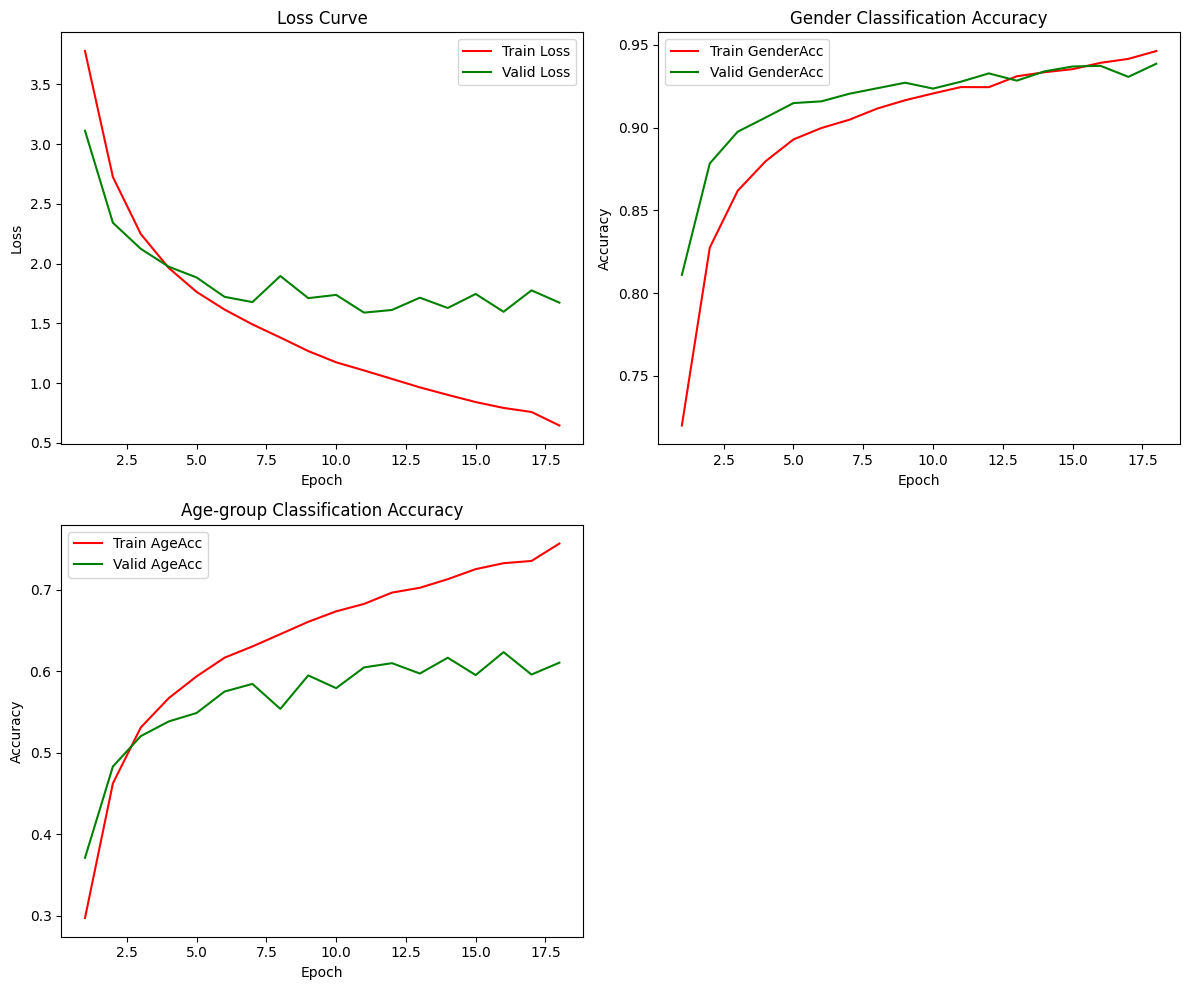

In [10]:
import matplotlib.pyplot as plt

epochs = range(1, len(hist["train_loss"]) + 1)

plt.figure(figsize=(12,10))

# 1) Loss curve
plt.subplot(2,2,1)
plt.plot(epochs, hist["train_loss"], 'r-', label="Train Loss")
plt.plot(epochs, hist["val_loss"],   'g-', label="Valid Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# 2) Gender Accuracy
plt.subplot(2,2,2)
plt.plot(epochs, hist["train_gender_acc"], 'r-', label="Train GenderAcc")
plt.plot(epochs, hist["val_gender_acc"],   'g-', label="Valid GenderAcc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Gender Classification Accuracy")
plt.legend()

# 3) Age-group Accuracy (Train vs. Valid)
plt.subplot(2,2,3)
plt.plot(epochs, hist["train_age_acc"], 'r-', label="Train AgeAcc")
plt.plot(epochs, hist["val_age_acc"],   'g-', label="Valid AgeAcc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Age-group Classification Accuracy")
plt.legend()
plt.tight_layout()
plt.savefig("training_summary.png")
plt.show()


In [15]:
from sklearn.metrics import classification_report, f1_score

all_true_age, all_pred_age = [], []
all_true_gen, all_pred_gen = [], []

model.eval()
with torch.no_grad():
    for images, age_g, gen in val_loader:
        images = images.to(device)
        gender_logits, age_logits = model(images)
        # 실제값/예측값 리스트에 추가
        all_true_age.extend(age_g.numpy())
        all_pred_age.extend(age_logits.argmax(1).cpu().numpy())
        all_true_gen.extend(gen.numpy())
        all_pred_gen.extend(gender_logits.argmax(1).cpu().numpy())

# — 연령대 리포트 —
print("\nAge-group classification report")
print(classification_report(all_true_age, all_pred_age,
      target_names=list(group_names.values())))
macro_f1_age = f1_score(all_true_age, all_pred_age, average='macro')
print(f"Macro-F1 (age groups): {macro_f1_age:.4f}")

# — 성별 리포트 —
gen_labels = ["Female", "Male"]
print("\nGender classification report")
print(classification_report(all_true_gen, all_pred_gen,
      target_names=gen_labels))
# Macro-F1 또는 binary-average로 계산할 수 있습니다
macro_f1_gen = f1_score(all_true_gen, all_pred_gen, average='macro')
print(f"Macro-F1 (gender): {macro_f1_gen:.4f}")



Age-group classification report
              precision    recall  f1-score   support

        0~10       0.78      0.94      0.85       943
       10~20       0.76      0.45      0.57      1315
       20~30       0.56      0.62      0.59      1193
       30~40       0.39      0.53      0.45       624
       40~50       0.50      0.46      0.48       486
       50 이상       0.68      0.72      0.70       239

    accuracy                           0.61      4800
   macro avg       0.61      0.62      0.61      4800
weighted avg       0.63      0.61      0.61      4800

Macro-F1 (age groups): 0.6063

Gender classification report
              precision    recall  f1-score   support

      Female       0.94      0.94      0.94      2500
        Male       0.94      0.93      0.94      2300

    accuracy                           0.94      4800
   macro avg       0.94      0.94      0.94      4800
weighted avg       0.94      0.94      0.94      4800

Macro-F1 (gender): 0.9384


/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/tmp/ipykernel_504/243962935.py:44: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=200)   # 파일로 저장
/tmp/ipykernel_504/243962935.py:44: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=200)   # 파일로 저장
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s

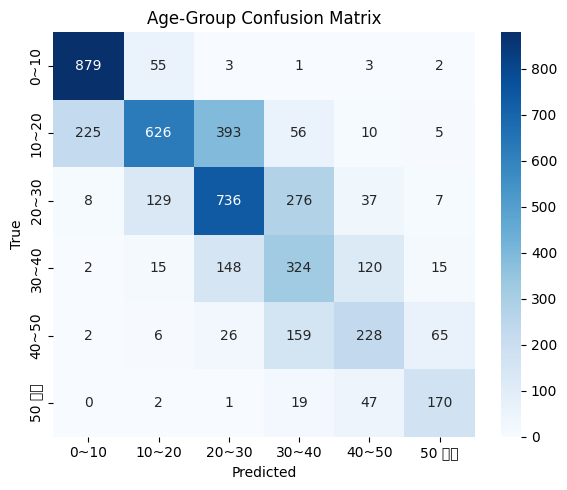

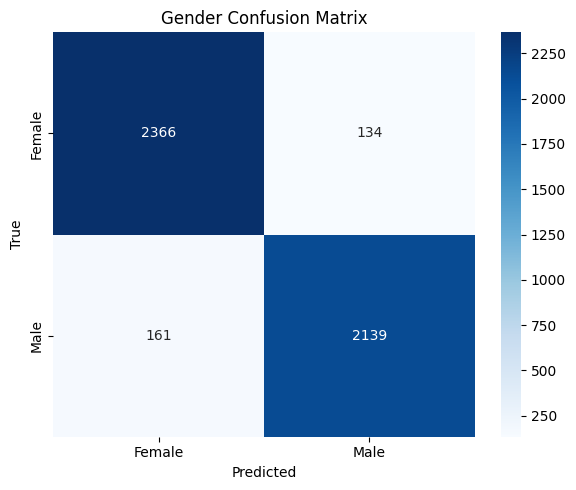

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns  # 시각화 편의를 위해 사용

# 1) 검증셋 전체를 돌며 예측 / 실제 레이블 수집
all_true_age, all_pred_age = [], []
all_true_gen, all_pred_gen = [], []

model.eval()
with torch.no_grad():
    for images, age_groups, genders in val_loader:
        images = images.to(device)
        gender_logits, age_logits = model(images)
        pred_age = age_logits.argmax(dim=1).cpu().numpy()
        pred_gen = gender_logits.argmax(dim=1).cpu().numpy()

        all_true_age.extend(age_groups.numpy())
        all_pred_age.extend(pred_age)
        all_true_gen.extend(genders.numpy())
        all_pred_gen.extend(pred_gen)

# 2) 클래스 이름 정의
age_labels = [group_names[i] for i in range(len(group_names))]
gen_labels = ["Female", "Male"]

# 3) 혼동 행렬 계산
cm_age = confusion_matrix(all_true_age, all_pred_age, labels=list(range(len(age_labels))))
cm_gen = confusion_matrix(all_true_gen, all_pred_gen, labels=[0,1])

# 4) 시각화 함수 (파일명까지 인자로 받아서 저장)
def plot_confusion(cm, labels, title, filename=None):
    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=labels, yticklabels=labels
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=200)   # 파일로 저장
    plt.show()
    plt.close()

# 5) 그리기 및 저장
plot_confusion(
    cm_age, age_labels,
    "Age-Group Confusion Matrix",
    filename="confusion_age.png"
)
plot_confusion(
    cm_gen, gen_labels,
    "Gender Confusion Matrix",
    filename="confusion_gender.png"
)


In [20]:
# 학습이 끝난 후 모델 상태 저장 (예: model_checkpoint.pt)
torch.save(model.state_dict(), "model_checkpoint.pt")
